In [1]:
import datetime
print('Last updated: ', datetime.datetime.now(), '(PT)')

Last updated:  2020-07-16 20:31:53.656124 (PT)


In [9]:
import json
import matplotlib.pyplot as plt
from jax import random
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
# from pyro.optim import Adam
# from pyro.infer import SVI, Trace_ELBO
# from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
# from pyro.contrib.autoguide import AutoDiagonalNormal
from numpyro.infer import MCMC, NUTS, HMC
import numpy as onp

In [40]:
# TFP:
# def stickbreak(v):
#     batch_ndims = len(v.shape) - 1
#     cumprod_one_minus_v = tf.math.cumprod(1 - v, axis=-1)
#     one_v = tf.pad(v, [[0, 0]] * batch_ndims + [[0, 1]], "CONSTANT", constant_values=1)
#     c_one = tf.pad(cumprod_one_minus_v, [[0, 0]] * batch_ndims + [[1, 0]], "CONSTANT", constant_values=1)
#     return one_v * c_one

# Stick break function
def stickbreak(v):
    batch_ndims = len(v.shape) - 1
    cumprod_one_minus_v = np.exp(np.log1p(-v).cumsum(-1))
    # cumprod_one_minus_v = np.cumprod(1-v, axis=-1)
    one_v = np.pad(v, [[0, 0]] * batch_ndims + [[0, 1]], constant_values=1)
    c_one = np.pad(cumprod_one_minus_v, [[0, 0]] * batch_ndims +[[1, 0]], constant_values=1)
    return one_v * c_one

# x = onp.random.randn(3, 2, 5)
# stickbreak(x);  # last dimension sums to 1.

In [41]:
# Custom distribution: Mixture of normals.
# This implements the abstract class `dist.Distribution`.
class NormalMixture(dist.Distribution):
    support = constraints.real_vector

    def __init__(self, mu, sigma, w):
        super(NormalMixture, self).__init__(event_shape=(1, ))
        self.mu = mu
        self.sigma = sigma
        self.w = w

    def sample(self, key, sample_shape=()):
        # it is enough to return an arbitrary sample with correct shape
        return np.zeros(sample_shape + self.event_shape)

    def log_prob(self, y, axis=-1):
        lp = dist.Normal(self.mu, self.sigma).log_prob(y) + np.log(self.w)
        return logsumexp(lp, axis=axis)

In [42]:
# Example:
# rng_key = random.PRNGKey(0)
# mu = dist.Normal(0, 1).sample(rng_key, (3, ))
# sig = dist.Uniform(0, 1).sample(rng_key, (3, ))
# w = np.array([.5, .3, .2])
# x = dist.Normal(0, 1).sample(rng_key, (10, 1))
# lp_x = NormalMixture(mu[None, :], sig[None, :], w[None, :]).log_prob(x[:, None])
# print(lp_x.shape)
# print(lp_x)

In [43]:
# DP SB GMM model.
# NOTE: In numpyro, priors are assigned to parameters in the following manner:
#
#   random_variable = numpyro.sample('name_of_random_variable', some_distribution)
#
# Note that random variables appear on the left hand side of the `numpyro.sample` statement.
# Data will appear *inside* the `numpyro.sample` statement, via the obs argument.
# 
# In this example, labels are explicitly mentioned. But they are, in fact, marginalized
# out automatically by numpyro. Hence, they do not appear in the posterior samples.
def dp_sb_gmm(y, num_components):
    # Cosntants
    N = y.shape[0]
    K = num_components
    
    # Priors
    # NOTE: In numpyro, the Gamma distribution is parameterized with shape and rate.
    # Hence, Gamma(shape, rate) => mean = shape/rate
    alpha = numpyro.sample('alpha', dist.Gamma(1, 10))
    
    with numpyro.plate('mixture_weights', K - 1):
        v = numpyro.sample('v', dist.Beta(1, alpha, K - 1))
    
    eta = stickbreak(v)
    
    with numpyro.plate('components', K):
        mu = numpyro.sample('mu', dist.Normal(0., 3.))
        sigma = numpyro.sample('sigma', dist.Gamma(1, 10))

    with numpyro.plate('data', N):
        numpyro.sample('obs', NormalMixture(mu[None, :] , sigma[None, :], eta[None, :]), obs=y[:, None])
    #     Local variables.
    #     label = numpyro.sample('label', dist.Categorical(eta))
    #     numpyro.sample('obs', dist.Normal(mu[label], sigma[label]), obs=y)

In [44]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
  simdata = json.load(f)

In [45]:
# Convert data to torch.tensor.
y = np.array(simdata['y'])

In [87]:
# %%time
# # Experimental, syntax not known.
# 
# # For ADVI
# from numpyro.infer import SVI, ELBO
# from numpyro.contrib.autoguide import AutoDiagonalNormal
# from numpyro.optim import Adam
# from functools import namedtuple
# from tqdm import trange
# from functools import namedtuple
# 
# # SVIState namedtuple
# SVIState = namedtuple('SVIState', ['optim_state', 'rng_key'])
# 
# # Set random seed for reproducibility.
# rng_key = random.PRNGKey(0)
# 
# # Automatically define variational distribution.
# guide = AutoDiagonalNormal(dp_sb_gmm)  # a mean field guide
# 
# # Adam Optimizer
# opt = Adam({'lr': 1e-2})
# # opt = numpyro.optim.optimizers.adam(0.01)
# 
# svi = SVI(dp_sb_gmm, guide, opt, ELBO())
# 
# # svi_state = SVIState(opt, rng_key)
# 
# # do gradient steps
# loss = []
# for step in trange(2000):
#     _loss = svi.update(svi_state, y=y, num_components=10)
#     loss.append(_loss)
#     
# # Plot ELBO    
# plt.plot(loss);

In [91]:
def get_posterior_samples(mcmc):
    # Get mu, sigma, v, alpha.
    posterior_samples = mcmc.get_samples()
    
    # Transform v to eta.
    posterior_samples['eta'] = stickbreak(posterior_samples['v'])
    
    return posterior_samples

In [92]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# NOTE: num_leapfrog = trajectory_length / step_size
kernel = HMC(dp_sb_gmm, step_size=.01, trajectory_length=1) 

hmc = MCMC(kernel, num_samples=500, num_warmup=500)
hmc.run(rng_key, y, 10)

hmc_samples = get_posterior_samples(hmc)

sample: 100%|██████████| 1000/1000 [00:10<00:00, 96.86it/s, 21 steps of size 4.57e-02. acc. prob=0.60] 


CPU times: user 13 s, sys: 223 ms, total: 13.2 s
Wall time: 12.6 s


In [93]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# Set up NUTS sampler.
kernel = NUTS(dp_sb_gmm, max_tree_depth=10, target_accept_prob=0.8)

nuts = MCMC(kernel, num_samples=500, num_warmup=500)
nuts.run(rng_key, y, 10)

nuts_samples = get_posterior_samples(nuts)

sample: 100%|██████████| 1000/1000 [00:27<00:00, 36.00it/s, 511 steps of size 7.51e-03. acc. prob=0.83] 


CPU times: user 30.4 s, sys: 235 ms, total: 30.6 s
Wall time: 30 s


In [94]:
def plot_param_post(params, param_name, param_full_name, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)
    param = params[param_name]

    plt.subplot(1, 2, 1)
    plt.boxplot(param.T, whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    plt.subplot(1, 2, 2)
    plt.plot(param);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

In [95]:
def plot_all_params(samples):
    # TODO: How to get log-likelihood?
    plot_param_post(samples, 'eta', 'mixture weights', truth=simdata['w'])
    plot_param_post(samples, 'mu', 'mixture means', truth=simdata['mu'])
    plot_param_post(samples, 'sigma', 'mixture scales', truth=simdata['sig'])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(samples['alpha'], bins=30, density=True);
    plt.xlabel("alpha")
    plt.ylabel("density")
    plt.title("Posterior distribution of alpha");

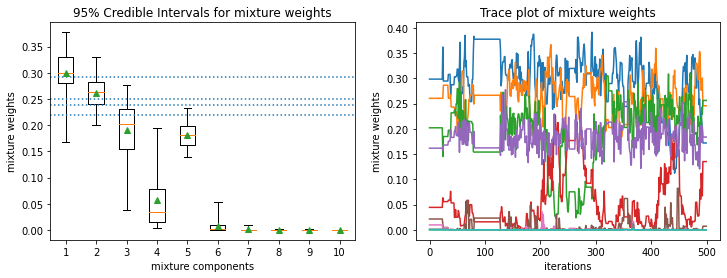

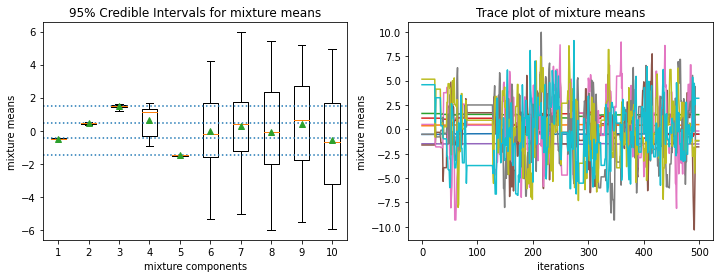

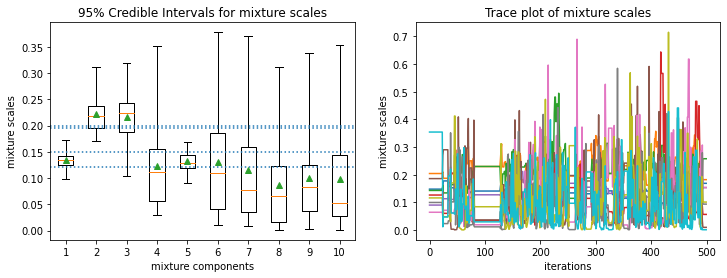

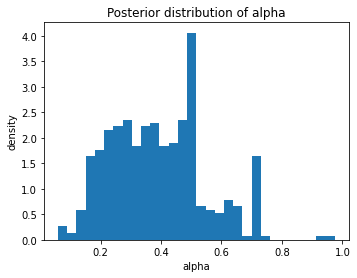

In [96]:
plot_all_params(hmc_samples)

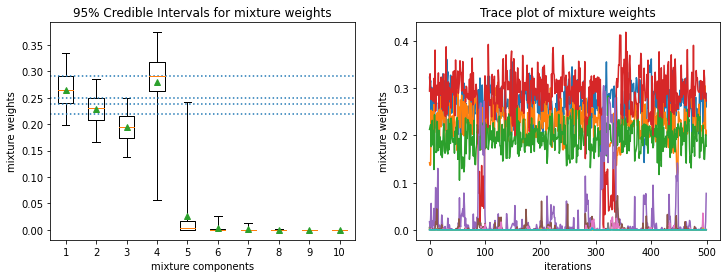

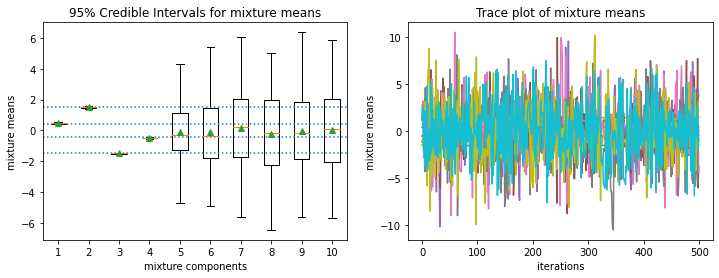

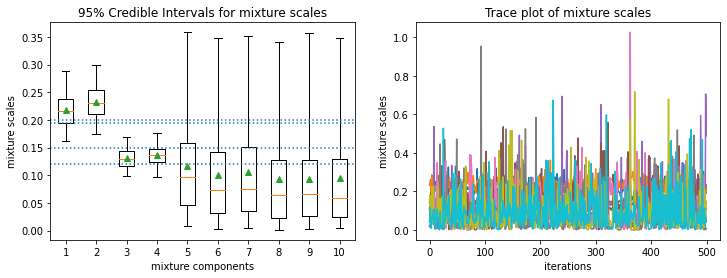

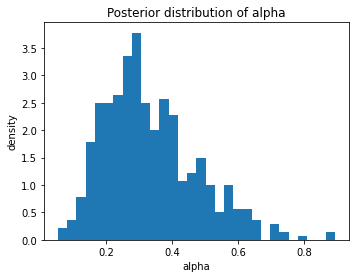

In [97]:
plot_all_params(nuts_samples)